# Treinamento de Redes Neurais Artificiais

**Disciplina:** Redes Neurais Artificiais 2025.1

**Professora orientadora:** 
Elloa B. Guedes (ebgcosta@uea.edu.br)

**Integrantes da equipe:**
* Adriana Raffaella Dos Santos Fonseca (ardsf.eng23@uea.edu.br)
* Ana Flavia De Castro Segadilha Da Silva (afdcsds.eng23@uea.edu.br)
* Davi Aguiar Moreira (dam.eng23@uea.edu.br)
* Guilherme Goncalves Moraes (ggm.eng23@uea.edu.br)
* Ian Garrido Reis (igr.eng23@uea.edu.br)
* Luiz Fernando Borges Brito (lfbb.eng23@uea.edu.br)
* Pedro Vitor Barros Maranhão (pvbm.eng23@uea.edu.br)
* Rita De Cassia Brasil Alves (rdcba.eng23@uea.edu.br)
* Yago De Oliveira Feitoza (ydof.eng21@uea.edu.br)

---

## **Importação das bibliotecas**

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

### **Importação e Holdout do dataset**

In [50]:
file_path = 'modified_star_classification.csv'

Data a expressiva quantidade de exemplos presentes no dataset, optou-se por dividir os dados por holdout 60/40. Além disso, a fim de possibilitar uma análise comparativa de abordagens posteriormente, utiliza-se um seed (42 por convenção).

In [53]:
df = pd.read_csv(file_path)

y = df['class']
X = df.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

### **Abordagem 1: 60/40**

Nesta abordagem, utiliza-se o holdout do modo como foi gerado anteriormente, isto é, sem o tratamento do desbalanceamento de dados. Nesse contexto, o conjunto de treinamento tem a seguinte composição: 59% dos são galáxias, 21% são estrelas e 18% são quasares. Desse modo, utilizam-se métricas ponderadas para permitir uma análise de resultados de acordo com a desigualdade no número de exemplos por classes.

In [57]:
first_model = MLPClassifier(
    hidden_layer_sizes=(32, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    n_iter_no_change=10,
    max_iter=200,
    random_state=42,
    early_stopping=True
)

first_model.fit(X_train_std, y_train)

y_pred = first_model.predict(X_test_std)

In [59]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Revocação: {recall:.4f}')
print(f'F1-Score: {f1_weighted:.4f}')

Acurácia: 0.9706
Precisão: 0.9705
Revocação: 0.9706
F1-Score: 0.9704


### **Abordagem 2: Downsampling**

Esta abordagem se dá por downsampling, i.e., iguala-se a quantidade de exemplos para cada dado a fim de permitir que o treinamento do analise a mesma quantidade de exemplos para cada classe.

**Balanceando as classes**

In [64]:
X_train_std_df = pd.DataFrame(X_train_std, columns=X.columns, index=X_train.index)
X_test_std_df = pd.DataFrame(X_test_std, columns=X.columns, index=X_test.index)
train_df = pd.concat([X_train_std_df, y_train], axis=1)

class_counts = train_df['class'].value_counts()

min_count = class_counts.min()

balanced_dfs = []

for class_name in class_counts.index:
    class_df = train_df[train_df['class'] == class_name]
    balanced_dfs.append(class_df.sample(min_count, random_state=42))

balanced_train_df = pd.concat(balanced_dfs)

X_train_balanced = balanced_train_df.drop('class', axis=1)
y_train_balanced = balanced_train_df['class']


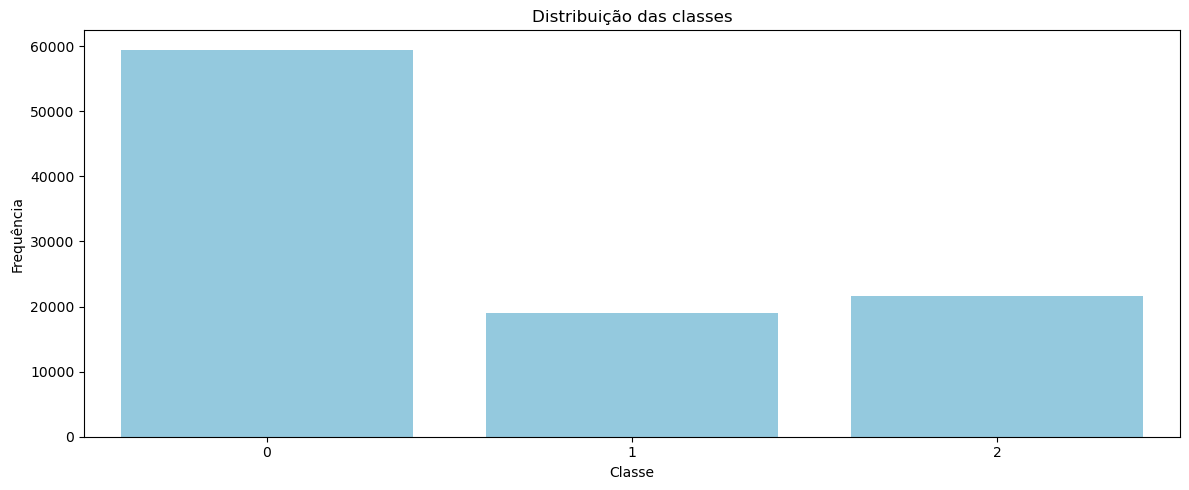

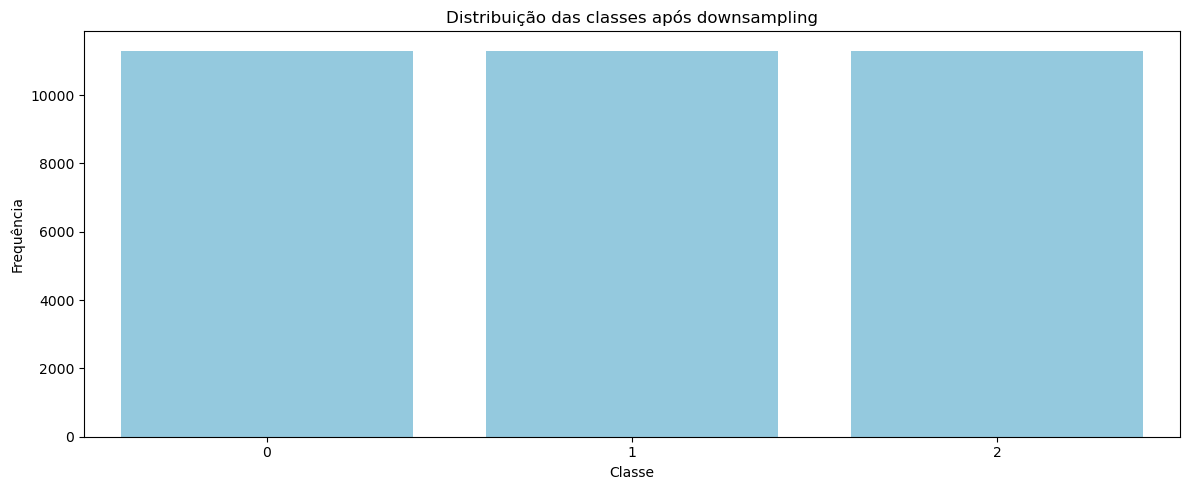

In [66]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='class', color='skyblue')
plt.title(f'Distribuição das classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
print()

plt.figure(figsize=(12, 5))
sns.countplot(data=balanced_train_df, x='class', color='skyblue')
plt.title(f'Distribuição das classes após downsampling')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
print()

**Treinamento**

In [69]:
second_model = MLPClassifier(
    hidden_layer_sizes=(32, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    n_iter_no_change=10,
    max_iter=200,
    random_state=42,
    early_stopping=True
)

second_model.fit(X_train_balanced, y_train_balanced)

y_pred = second_model.predict(X_test_std_df)

In [71]:
accuracy_down = accuracy_score(y_test, y_pred)
precision_down = precision_score(y_test, y_pred, average='weighted')
recall_down = recall_score(y_test, y_pred, average='weighted')
f1_weighted_down = f1_score(y_test, y_pred, average='weighted')

print(f'Acurácia: {accuracy_down:.4f}')
print(f'Precisão: {precision_down:.4f}')
print(f'Revocação: {recall_down:.4f}')
print(f'F1-Score: {f1_weighted_down:.4f}')

Acurácia: 0.9691
Precisão: 0.9693
Revocação: 0.9691
F1-Score: 0.9692


**Análise de métricas**

Diante da análise dos valores de F1-Score de ambas as abordagens para o mesmo conjunto de testes, nota-se proximidade entre os valores. Tal proximidade se deu para uma única execução de um único modelo para cada abordagem, sendo possível que outras execuções favoreçam uma abordagem em dentrimento da outra.

Nesse cenário, a segunda abordagem mostra-se viável, dado que permite a obtenção de um métrica próxima à primeira, com uma quantidade de dados muito menor.